Point of notebook: 
Check gridding in the products that go into the restart DIC file. 

Justification/Summary of approach:
the carbon content of the oceans changes through time, so to get the carbon content of the ocean at any one given year, we take the contemporary carbon content product, subtract an estimate of **contemporary** *anthropogenic* carbon content, and add back an estimate of *anthropogenic* carbon content for the target year.

Process:

1) take MOBO-dic product monthly, call it year 2011
    - we also need to deal with the poles. xx- talk to PT about this
2) get anthropogenic carbon to 1994 
3) get anthropogenic carbon 1994-2007
4) add 2 and 3 to get canth to 2007
5) then you can scale product from 4) quite simply to get all the canths. 
6) then to get pseudo-obs DIC you get DIC_yearX:
    - DIC_year2011-CAnt_year2011 + CAnt_yearX
7) note products 1, 2, 3 and therefore any lin. combination of those are all in umol/kg and *YOU THEN NEED TO CONVERT TO UMOL/L.*, double check this. 
    
    
Where it's gone wrong: 
    I suspect 1), 2), and 3) are all on different grids and I just assumed they were on the glodap grid and it went wonky. 
    
Point of notebook: 
Check the grids for 1), 2), 3). adjust accordingly. 
- Either regrid 1) 2) and 3) onto ORCA and then deal with steps 4 and onwards 
- or make sure 1) 2) and 3) are on GLODAP, do the 



In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## product 1) , MOBO-DIC, grid check

(12, 33, 130, 360)

only goes -65 to +65 in latitude, ignores poles

(12, 33, 130, 360)


Text(0.5, 1.0, 'MOBO-dic lon deg')

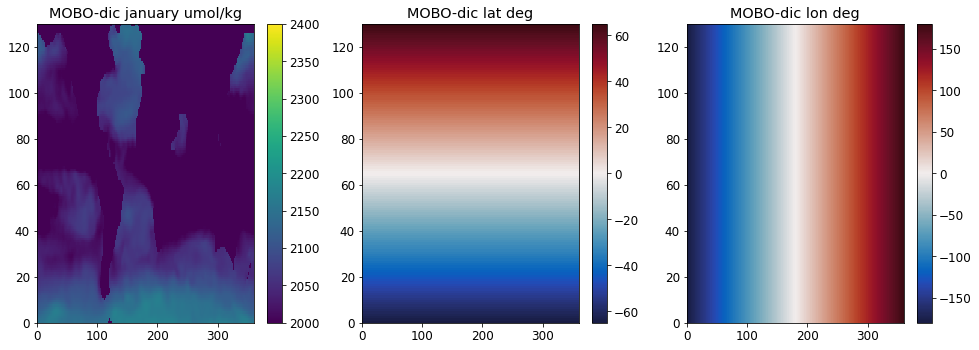

In [39]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/datasets/MOBO-DIC_MPIM_monthly_clim.nc'
MOBO = xr.open_dataset(tdir)
tDIC = MOBO['DIC'].values
print(np.shape(tDIC))
mobolat = MOBO.lat.values
mobolon = MOBO.lon.values

mobolatv, mobolonv = np.meshgrid(mobolat, mobolon, indexing='ij')


tlat = np.arange(-89.5,90.5,1)
# len(tlat)
# print(np.where(tlat == -64.5))
# print(tlat[25])
DIC_fg = np.zeros([12,33,180,360])
DIC_fg[:,:,25:25+130:,:] = tDIC

fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(33*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
tw = axs[0].pcolormesh(tDIC[0,0,:,:], vmin = 2000, vmax = 2400)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('MOBO-dic january umol/kg')

tw = axs[1].pcolormesh(mobolatv, vmin = -65, vmax = 65, cmap = cm.balance)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('MOBO-dic lat deg')

tw = axs[2].pcolormesh(mobolonv, vmin = -180, vmax = 180, cmap = cm.balance)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('MOBO-dic lon deg')

## product 2) , Canth to 1994, grid check. 

size (33, 180, 360)

(33, 180, 360)


Text(0.5, 1.0, 'anth94-dic lon deg')

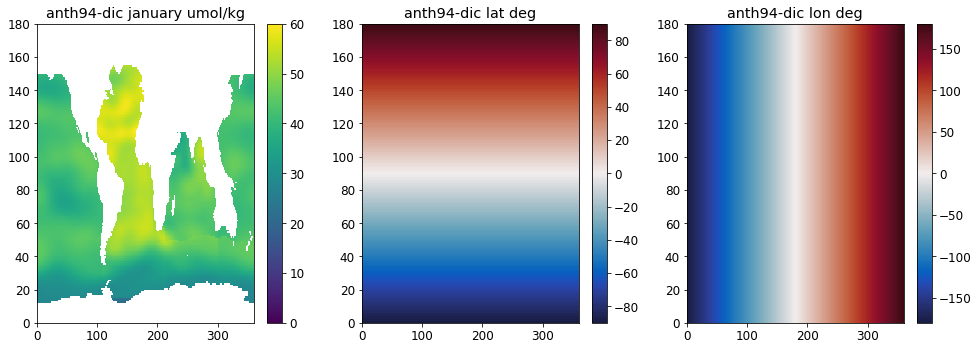

In [36]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/datasets/AnthCO2'
anth94 = xr.open_dataset(f'{tdir}/AnthCO2.nc')

anth94lat = anth94.latitude.values
anth94lon = anth94.longitude.values
anth94latv, anth94lonv = np.meshgrid(anth94lat, anth94lon, indexing='ij')

ACO2_1994 = anth94['AnthCO2'].values
ACO2_1994 = np.swapaxes(ACO2_1994, 1, 2)
print(np.shape(ACO2_1994))

fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(33*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
tw = axs[0].pcolormesh(ACO2_1994[0,:,:], vmin = 0, vmax = 60)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('anth94-dic january umol/kg')

tw = axs[1].pcolormesh(anth94latv, vmin = -90, vmax = 90, cmap = cm.balance)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('anth94-dic lat deg')

tw = axs[2].pcolormesh(anth94lonv, vmin = -180, vmax = 180, cmap = cm.balance)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('anth94-dic lon deg')

## product 3), canth 1994-2007, grid check

Text(0.5, 1.0, 'anth9407-dic lon deg')

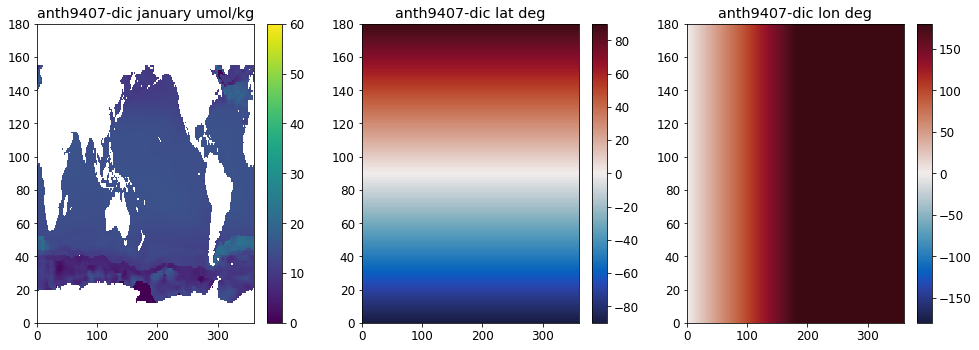

In [42]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/datasets/'
anth9407 = xr.open_dataset(f'{tdir}/dcant_emlr_cstar_gruber_94-07_vs1.nc')
anthco2_9407 = anth9407['DCANT_01'].values
anth9407
anth9407lat = anth9407.LATITUDE.values
anth9407lon = anth9407.LONGITUDE.values
anth9407latv, anth9407lonv = np.meshgrid(anth9407lat, anth9407lon, indexing='ij')

fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(33*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
tw = axs[0].pcolormesh(anthco2_9407[0,:,:], vmin = 0, vmax = 60)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('anth9407-dic january umol/kg')

tw = axs[1].pcolormesh(anth9407latv, vmin = -90, vmax = 90, cmap = cm.balance)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('anth9407-dic lat deg')

tw = axs[2].pcolormesh(anth9407lonv, vmin = -180, vmax = 180, cmap = cm.balance)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('anth9407-dic lon deg')

## ok yes there is the problem. gruber's product USES THE SAME GRID AS THE PREVIOUS TWO BUT IS SHIFTED BY A BUNCH AND ALSO USES A DIFFERENT LONGITUDE NOTATION. 

<xarray.Dataset>
Dimensions:   (depth: 33, lat: 180, lon: 360)
Coordinates:
  * depth     (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    Anth_DIC  (depth, lat, lon) float32 ...
Attributes:
    made in:  Tuning/ML-GLODAPPseudoObsForRestart.ipynb

In [7]:
test_anthDIC

anthlat = test_anthDIC.lat.values
anthlon = test_anthDIC.lon.values

anthlatv, anthlonv = np.meshgrid(anthlat, anthlon, indexing='ij')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


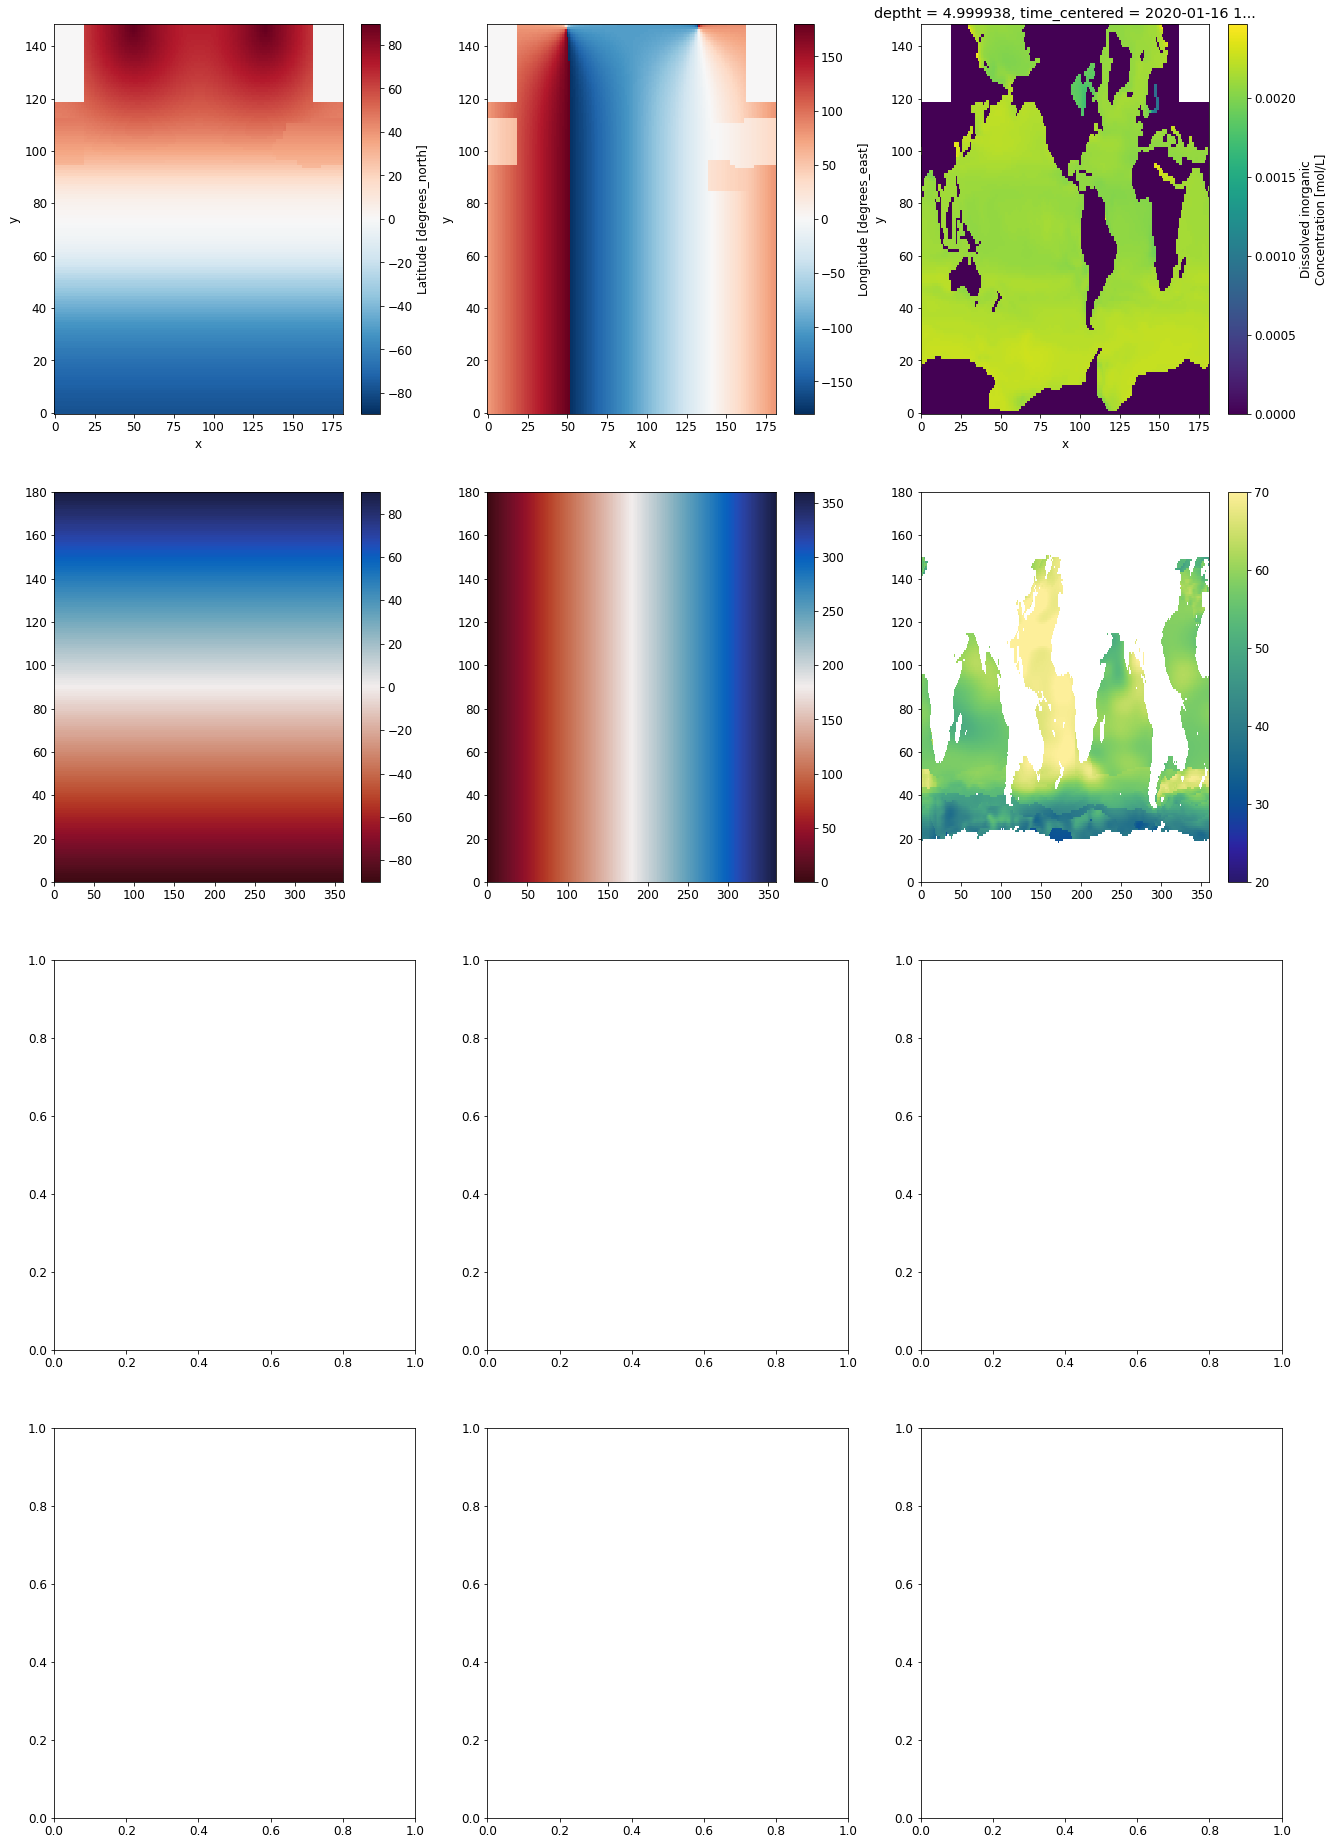

In [8]:
fact = 1.1
fig, axs = plt.subplots(4,3, figsize=(20*fact, 30*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

xr.plot.pcolormesh(test_mod.nav_lat, ax = axs[0])
xr.plot.pcolormesh(test_mod.nav_lon, ax = axs[1])

xr.plot.pcolormesh(test_mod.DIC.isel(deptht=0).isel(time_counter = 0), ax = axs[2])

mesh= axs[3].pcolormesh(anthlatv, cmap=cm.balance_r, vmin=-90, vmax=90)
cbar = plt.colorbar(mesh, ax = axs[3])
mesh= axs[4].pcolormesh(anthlonv, cmap=cm.balance_r, vmin=0, vmax=360)
cbar = plt.colorbar(mesh, ax = axs[4])
mesh= axs[5].pcolormesh(test_anthDIC.Anth_DIC.isel(depth=0), cmap=cm.haline, vmin=20, vmax=70)
cbar = plt.colorbar(mesh, ax = axs[5])
# xr.plot.pcolormesh(test_mod.nav_lon, ax = axs[1])


# xr.plot.pcolormesh(test_anthDIC.lat, ax = axs[2])
# xr.plot.pcolormesh(test_anthDIC.lon, ax = axs[3])